In [ ]:
###TEAM
###Aida Alexandra Granda Cardenas
###Oscar Arturo Silva Castellanos

# Set the stage
from google.colab import drive
import cv2, math, time
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
M = np.array([[2,1],[1,4]])
D,V = np.linalg.eig(M)

In [ ]:
#This functions checks is the lines produced are more or less horizontal
def is_horizontal(x1, x2, y1, y2, THRESHOLD=10):
    if abs(x1 - x2) < THRESHOLD and abs(y1 - y2) > 10:
      return False
    if abs(y1 - y2) < THRESHOLD and abs(x1 - x2) > 10:
      return True
    return None

#This function allows to select lines that will be part of the square of the snooker table
def find_important_lines(lines):
    min_horizontal = float('inf')
    max_horizontal = float('-inf')
    
    min_vertical = float('inf')
    max_vertical = float('-inf')

    response = [min_horizontal, max_horizontal, min_vertical, max_vertical]
    for i in range(len(lines)):
        x1, x2, y1, y2 = lines[i][0], lines[i][1], lines[i][2], lines[i][3]
        is_horz = is_horizontal(x1, x2, y1, y2)
        #print(is_horz)

        if is_horz == None:
          continue
        if is_horz:
            if max(y1, y2) > max_horizontal:
                response[1] = lines[i]
                max_horizontal = max(y1, y2)
            if min(y1, y2) < min_horizontal:
                response[0] = lines[i]
                min_horizontal = min(y1, y2)
        else:
            if max(x1, x2) > max_vertical:
                response[3] = lines[i]
                max_vertical = max(x1, x2)
            if min(x1, x2) < min_vertical:
                response[2] = lines[i]
                min_vertical = min(x1, x2)
    return response

#function two find the 4 intersecctions of the rectangle located in the table
def line_instersection(lines):
  horz=[]
  vert=[]

  for line in lines :
    if is_horizontal(line[0],line[1],line[2],line[3]):
      horz.append(line)
    else:
      vert.append(line)

  intersection_points = []
  for line in horz:
    intersection_points.append([vert[0][0],line[2]])
    intersection_points.append([vert[1][0],line[2]])
  
  return intersection_points

#We use Sobel to find the edges of our threshold
def find_edges(img_thresh):
  G_x = cv2.Sobel(img_thresh,cv2.CV_64F,0,1)
  G_y = cv2.Sobel(img_thresh,cv2.CV_64F,1,0)
  G = np.abs(G_x) + np.abs(G_y)
  G = np.sqrt(np.power(G_x,2)+np.power(G_y,2))
  G[G >255] = 255
  edges=G.astype( 'uint8')

  return edges
  
  #plt.imshow(G)

def f_all_lines(lines):

  all_lines = []
  if lines is not None:
      print(lines.shape[0])
      for line in lines:



                rho, theta = line[0][0], line[0][1]
                print(f"rho={rho},theta ={theta}")
                #print(rho,theta)
                a = np.cos(theta)
                b = np.sin(theta)

                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 4000*(-b))
                y1 = int(y0 + 4000*(a))
                x2 = int(x0 - 4000*(-b))
                y2 = int(y0 - 4000*(a))

                all_lines.append([x1, x2, y1, y2])

  return all_lines



In [ ]:
#Function to proccess each frame
def snooker_find(image,h):
  
  #Image Resizing
  image_re=cv2.resize(image,(int(image.shape[1]),int(image.shape[0]))  ,interpolation = cv2.INTER_AREA)
  

  image_re = image_re[255:312,:]
  cv2_imshow(image_re)
  
  # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  # pts_src=np.array(([[338,	257],[233	,257], [352 ,	288],[180	,288] ]))
  # #pts_src=np.array(([[257,	338],[257	,233], [288 ,	352],[288	,180] ]))
  # pts_dst =np.array(([[338 ,	257] , [276	,257], [338	, 319], [276,	319]]))
  # #pts_dst =np.array(([[257 ,	338] , [257	,276], [319	, 338], [319,	276]]))

  # h, status = cv2.findHomography( pts_src,pts_dst)

  im_dst = cv2.warpPerspective(image, h, (640,360))
  #print(im_dst)
  cv2_imshow(im_dst)

  # 295	341
  # 351	341
  # 295	290
  # 351	290

  image_re = im_dst[290:341,295:351]


  #Applying Gaussian Blur Before Thresholding
  #Since we know that the surface of the board is green we will only retain the green color channel to obtain better results
  blur = cv2.GaussianBlur(image_re[:,:,:],(5,5),0)

  #Applying Thresholding
  ret3,th2 = cv2.threshold(blur,90,255,cv2.THRESH_BINARY_INV)
  #ret3,th3 = cv2.threshold(blur,90,255,cv2.THRESH_OTSU)
  cv2_imshow(th2)
  #cv2_imshow(th3)

  #Finding the edges of the boards
  edges=find_edges(th2)
  cv2_imshow(edges)
  #plt.axis('off')
  #plt.show()

  edges= cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
  #Finding the HoughLines from our threshold image
  lines = cv2.HoughLines(edges, 1, np.pi/180, 50)
  
  #print(np.shape(lines))
  
  #Hough lines returns the polar coordinates of line we will transform them to cartesian
  #The following part comes from the CV2 documentation
  #https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
  all_lines = []
  if lines is not None:
      print(lines.shape[0])
      for line in lines:



                rho, theta = line[0][0], line[0][1]
                print(f"rho={rho},theta ={theta}")
                #print(rho,theta)
                a = np.cos(theta)
                b = np.sin(theta)

                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 4000*(-b))
                y1 = int(y0 + 4000*(a))
                x2 = int(x0 - 4000*(-b))
                y2 = int(y0 - 4000*(a))

                all_lines.append([x1, x2, y1, y2])
            
      for line in all_lines:
              image_re = cv2.line(image_re,(line[0],line[2]), (line[1],line[3]), (0, 0, 255), 1)

  cv2_imshow(image_re)

  #We only retain the most important lines 
  # important_lines = find_important_lines(all_lines)

  #We obtain the intersection points given by our lines
  # ips = line_instersection(important_lines)
  #Draw rectangle of the table  over our resized image
  # cv2.rectangle(image_re, (ips[0][0],ips[0][1]),  (ips[3][0],ips[3][1]), (0, 0, 255), 2)
  #cv2.imwrite ('houghlines3.jpg' , image_re)



  # #cropping the image
  # error = 25 # Cropping some extra borders just to avoid detecting additional figures
  # cropped = image_re[ips[0][1]+error:ips[2][1]-error,ips[0][0]+error:ips[3][0]-error]

  #If for some reason the square given by ourcountiring fails 

  # if cropped.shape[0] >0  and  cropped.shape[1] > 0:

  #   #In this case we are keeping only the read channel for drawing the threshould for the balls    
  #   blur2 = cv2.GaussianBlur(cropped[:,:,2],(5,5),0)
  #   ret3,thresh = cv2.threshold(blur2,90,255,cv2.THRESH_BINARY)
  #   #cv2_imshow(blur2)
  #   #cv2_imshow(thresh)



    # #Are the boundaries of a shape with same intensity. 
    # #Find Contours stores the (x,y) coordinates of the boundary of a shape. 
    # #cv2.CHAIN_APPROX_SIMPLE option only stores the most relevant points saving memory
    # circs = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # if len(circs) == 2 :
    #   circs_f= circs[0]
    # else:
    #   circs_f=circs[1]


   
  
  return image_re,edges,th2







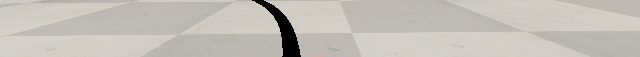

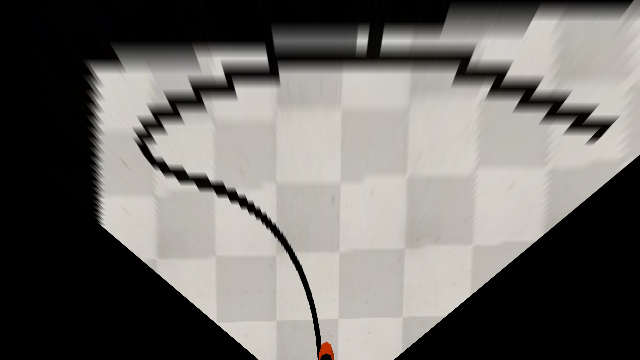

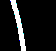

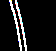

3
rho=-10.0,theta =2.9146997928619385
rho=-16.0,theta =2.949606418609619
rho=-15.0,theta =2.9321532249450684


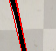

In [ ]:
pts_src=np.array(([[338,	257],[233	,257], [352 ,	288],[180	,288] ]))
pts_dst =np.array(([[338 ,	257] , [276	,257], [338	, 319], [276,	319]]))
h1, status = cv2.findHomography(pts_src,pts_dst)
#SAMPLE=cv2.imread("drive/MyDrive/image.png")
SAMPLE=cv2.imread("drive/MyDrive/saved_image.jpg")
SAMPLE
a=snooker_find(SAMPLE,h1)

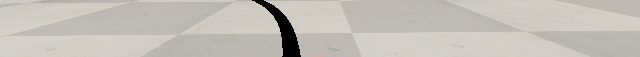

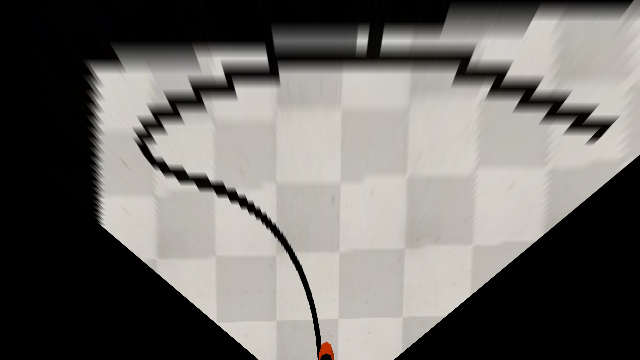

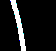

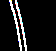

3
rho=-10.0,theta =2.9146997928619385
rho=-16.0,theta =2.949606418609619
rho=-15.0,theta =2.9321532249450684


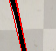

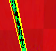

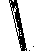

(51, 56)
38
53
mask


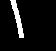

[[2 1]
 [1 4]]


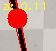

-11.0
0.11


In [ ]:
a=snooker_find(SAMPLE,h1)
hsv = cv2.cvtColor(a[0], cv2.COLOR_BGR2HSV)
cv2_imshow(hsv)
lower_yellow = np.array([ 2, 2, 2])
upper_yellow = np.array([255,200 , 255])
mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
cv2_imshow(mask)
print(mask.shape)

mask=cv2.cvtColor(a[2],cv2.COLOR_BGR2GRAY)

h, w, d = a[0].shape
search_top = int(round(3*h/4,0))
print(search_top)
search_bot = int(round(3*h/4,0)) +15
print(search_bot)

mask[38:h, 0:w] = 0
#mask[0:25, 0:w] = 0
#mask[search_bot:h, 0:w] = 0
#mask[25:51, 0:w] = 0
#mask[search_bot:h, 0:w]
print("mask")
cv2_imshow(mask)
print(M)
M = cv2.moments(mask, cv2.COLOR_BGR2GRAY)
if M['m00'] > 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv2.circle(a[0], (cx, cy), 10, (0,0,255), -1)
#The proportional controller is implemented in the following four lines which
#is reposible of linear scaling of an error to drive the control output.
        err = cx - w/2
        #self.twist.linear.x = 0.2
        angular = -float(err) / 100
cv2.putText(a[0], text="a: "+str(angular),org=(2,10), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=.80, color=(50,250,240), thickness=1)
cv2_imshow( a[0])
print(err)
print(angular)

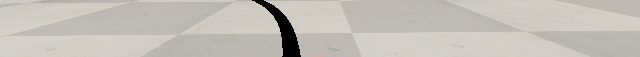

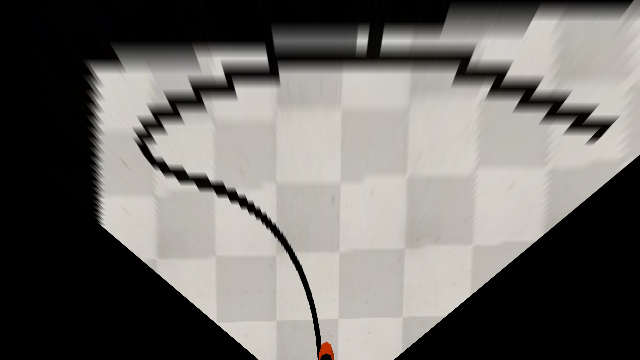

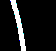

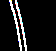

3
rho=-10.0,theta =2.9146997928619385
rho=-16.0,theta =2.949606418609619
rho=-15.0,theta =2.9321532249450684


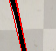

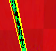

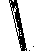

(51, 56)
(51, 56)
0 5


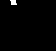

5 10


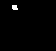

10 15


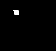

15 20


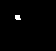

20 25


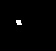

25 30


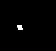

30 35


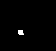

35 40


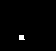

40 45


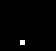

45 50


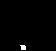

In [ ]:
future_pos=[None]*10
a=snooker_find(SAMPLE,h1)
hsv = cv2.cvtColor(a[0], cv2.COLOR_BGR2HSV)
cv2_imshow(hsv)
lower_yellow = np.array([ 2, 2, 2])
upper_yellow = np.array([255,200 , 255])
mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
cv2_imshow(mask)
print(mask.shape)

mask=cv2.cvtColor(a[2],cv2.COLOR_BGR2GRAY)
print(mask.shape)
for i in range(0, 10):
    mask_range_bot=(i)*5
    mask_range_top=(i+1)*5
    print(mask_range_bot,mask_range_top)
    mask=cv2.cvtColor(a[2],cv2.COLOR_BGR2GRAY)
    mask[0:mask_range_bot, 0:w] = 0
    mask[mask_range_top:h, 0:w]=0

    M = cv2.moments(mask)
    err=0
    if M['m00'] > 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            future_pos[i]=[cx,cy]
            #cv2.circle(mask, (cx, cy), 10, (255,255,255), -1)

    cv2_imshow(mask)

            #The proportional controller is implemented in the following four lines which
            #is reposible of linear scaling of an error to drive the control output.
        #self.twist.linear.x = 0.2

In [ ]:
future_pos

[[13, 2],
 [14, 7],
 [15, 11],
 [17, 17],
 [18, 21],
 [19, 27],
 [20, 32],
 [21, 37],
 [21, 41],
 [22, 47]]

In [ ]:
a[0].shape

(51, 56, 3)

1.11


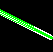

In [ ]:

SAMPLE=cv2.imread("drive/MyDrive/test8.png")
SAMPLE

edges= cv2.cvtColor(SAMPLE, cv2.COLOR_BGR2GRAY)
  #Finding the HoughLines from our threshold image
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50,5,5)
a=b=0

if lines is not None:
    for line in lines:

        for x1,y1,x2,y2 in line:
            cv2.line(SAMPLE,(x1,y1),(x2,y2),(0,255,0),1)
            a+=x2-x1
            b+=y2-y1

            r_angle = round(math.atan2(x2-x1,y2-y1),2)
                
                
    s=np.shape(lines)
    average_angle = round(math.atan2(a/s[0],b/s[0]),2)
    print(average_angle)
cv2_imshow(SAMPLE)


In [ ]:

##Outputtingvideo

drive.mount('/content/drive/')

A = cv2.VideoCapture("drive/MyDrive/snooker-snippet.mp4")

success,read_frame = A.read()
res_output = (int(read_frame.shape[1] / 2), int(read_frame.shape[0] / 2))
codec = cv2.VideoWriter_fourcc(*'MP4V')

#The original video was #25fps second since we are only keeping half the frames we reduced it to 12
output = cv2.VideoWriter('snooker_lines.mp4', codec, 12.0, res_output)	

i=0
#Keep adding frames until it reads the complete video
while success:
  #Only even frames
  if i % 2 == 0: 
    frame = snooker_find(read_frame)
    output.write(frame)

    if i % 300 == 0:
      print(f"Frames processed:{i}")

  i+= 1
  success,read_frame = A.read()

output.release()

  



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


TypeError: ignored

In [ ]:
#Function to proccess each frame
def snooker_find2(image,h):
  
  #Image Resizing
  image_re=cv2.resize(image,(int(image.shape[1]),int(image.shape[0]))  ,interpolation = cv2.INTER_AREA)
  

  image_re = image_re[255:312,:]
  cv2_imshow(image_re)
  
  # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  # pts_src=np.array(([[338,	257],[233	,257], [352 ,	288],[180	,288] ]))
  # #pts_src=np.array(([[257,	338],[257	,233], [288 ,	352],[288	,180] ]))
  # pts_dst =np.array(([[338 ,	257] , [276	,257], [338	, 319], [276,	319]]))
  # #pts_dst =np.array(([[257 ,	338] , [257	,276], [319	, 338], [319,	276]]))

  # h, status = cv2.findHomography( pts_src,pts_dst)

  im_dst = cv2.warpPerspective(image, h, (640,360))
  #print(im_dst)
  cv2_imshow(im_dst)

  # 295	341
  # 351	341
  # 295	290
  # 351	290

  image_re = im_dst[290:341,295:351]


  #Applying Gaussian Blur Before Thresholding
  #Since we know that the surface of the board is green we will only retain the green color channel to obtain better results
  blur = cv2.GaussianBlur(image_re[:,:,:],(5,5),0)

  #Applying Thresholding
  ret3,th2 = cv2.threshold(blur,90,255,cv2.THRESH_BINARY_INV)
  #ret3,th3 = cv2.threshold(blur,90,255,cv2.THRESH_OTSU)
  cv2_imshow(th2)
  #cv2_imshow(th3)

  #Finding the edges of the boards
  edges=find_edges(th2)
  cv2_imshow(edges)
  #plt.axis('off')
  #plt.show()

  edges= cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
  #Finding the HoughLines from our threshold image
  lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50,3,20)
  
  #print(np.shape(lines))
  
  #Hough lines returns the polar coordinates of line we will transform them to cartesian
  #The following part comes from the CV2 documentation
  #https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
  all_lines = []
  if lines is not None:
      print(lines.shape[0])
      print(lines)
      print(lines[1])
      for line in lines:


                print(line)
                # rho, theta = line[0][0], line[0][1]
                # print(f"rho={rho},theta ={theta}")
                # #print(rho,theta)
                # a = np.cos(theta)
                # b = np.sin(theta)

                # x0 = a*rho
                # y0 = b*rho
                # x1 = int(x0 + 4000*(-b))
                # y1 = int(y0 + 4000*(a))
                # x2 = int(x0 - 4000*(-b))
                # y2 = int(y0 - 4000*(a))

                # all_lines.append([x1, x2, y1, y2])
                for x1,y1,x2,y2 in line:
                  cv2.line(image_re,(x1,y1),(x2,y2),(0,255,0),2)
  cv2_imshow(image_re)

   
  
  return image_re,edges,th2







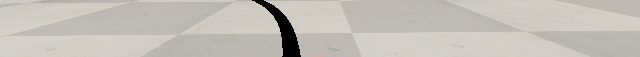

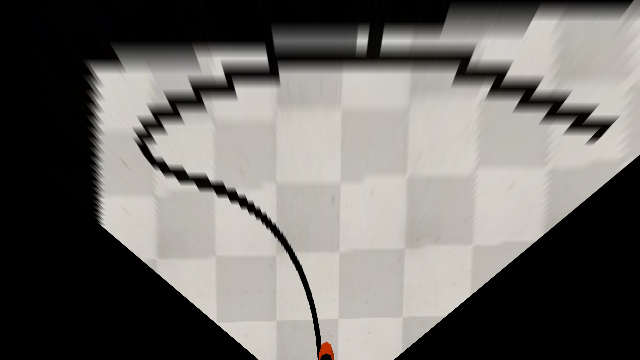

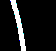

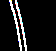

2
[[[18  7 26 50]]

 [[10  0 15 23]]]
[[10  0 15 23]]
[[18  7 26 50]]
[[10  0 15 23]]


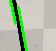

In [ ]:
pts_src=np.array(([[338,	257],[233	,257], [352 ,	288],[180	,288] ]))
pts_dst =np.array(([[338 ,	257] , [276	,257], [338	, 319], [276,	319]]))
h1, status = cv2.findHomography(pts_src,pts_dst)
#SAMPLE=cv2.imread("drive/MyDrive/image.png")
SAMPLE=cv2.imread("drive/MyDrive/saved_image.jpg")
SAMPLE
a=snooker_find2(SAMPLE,h1)

In [ ]:
# importing required libraries
# importing required libraries
import mahotas
import mahotas.demos
from pylab import gray, imshow, show
import numpy as np


SAMPLE=cv2.imread("drive/MyDrive/test10.png")

# loading image
#img = mahotas.demos.load('lena')
cv2.HoughCircles( gray, circles, CV_HOUGH_GRADIENT, 1, 60, 200, 20, 0, 0 );

img=SAMPLE
# grey image
g = img[:, :, 1]
 
# multiplying grey image values
g = g * 100
  
# filtering image
img = img.max(2)

cv2.HoughCircles( gray, circles, CV_HOUGH_GRADIENT, 1, 60, 200, 20, 0, 0 );

  
# showing image

# getting center of mass
center = mahotas.center_of_mass(img)
cv2.circle( SAMPLE, (int(center[0]), int(center[1])), 10, (255,0,255), -1)

cv2_imshow(SAMPLE)

  
# printing center of mass co-ordinate
print("Center of Mass : " + str(center))

ModuleNotFoundError: ignored

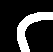

[[[36.5 33.5 21. ]]]
33.5


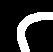

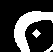

In [ ]:

prueba=np.zeros_like(img)

img = cv2.imread("drive/MyDrive/test10.png")
prueba=np.zeros_like(img)
img = cv2.medianBlur(img,5)

cv2_imshow(cimg)
prueba=np.zeros_like(img)
cimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
prueba[:, :,0]=cimg
prueba[:, :,1]=cimg
prueba[:, :,2]=cimg
circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT,1,20,
                            param1=30,param2=10,minRadius=5,maxRadius=30)
#'circles = np.uint16(np.around(circles))'
print(circles)
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img,(int(i[0]),int(i[1])),int(i[2]),(255,255,255),2)
    # draw the center of the circle
    cv2.circle(img,(int(i[0]),int(i[1])),2,(255,255,255),3)

print(circles[0][0][1])
cv2_imshow(prueba)
cv2_imshow(img)

In [ ]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 4.7 MB/s 
